# Code Breakdown

- [0 - Inicialización](#0)

    - [0.1 - Librerías generales](#0.1)
    - [0.2 - Descarga de datos](#0.2)
- [1 - Helper Functions for Data Processing](#1)
    - [1.1 - Load Data](#1.1)
    - [1.2 - Pre-Process Data](#1.2)
    - [1.3 - Load and View Data](#1.3)
- [2 - Parte A: Clasificación](#2)
    - [2.1 - Subvivisión del dataset para clasificación](#2.1)
    - [2.2 - Preparación de los lotes para clasificación](#2.2)
    - [2.3 - Armado del modelo](#2.3)
        - [2.3.1 - CRNA - modelo y parámetros](#2.3.1)
        - [2.3.2 - Entrenamiento](#2.3.2)
    - [2.4 - Evaluación del modelo de clasificación](#2.4)
- [3 - Parte B: Segmentación](#3)
    - [3.1 - Process Data to segmentation](#3.1)
    - [3.2 - Split Train and Test](#3.2)
    - [3.3 - Armado del modelo](#3.3)
        - [3.3.1 - U-Net Encoder Block](#3.3.1)
        - [3.3.2 - U-Net Decoder Block](#3.3.2)
        - [3.3.3 - Compile U-Net Blocks](#3.3.3)
        - [3.3.4 - Compile and Run Model](#3.3.4)
    - [3.4 -  Evaluación del modelo de clasificación](#3.4)
        - [3.4.1 - Bias Variance Check](#3.4.1)
        - [3.4.2 - View Predicted Segmentations](#3.4.2)

<a name='0'></a>
# 0 - Inicialización

<a name='0.1'></a>
## 0.1 - Librerías Generales

In [1]:
# for data y data load
import numpy as np # for using np arrays
import pandas as pd
import os
import shutil
from shutil import copyfile

# for reading and processing images
import imageio
from PIL import Image
import cv2

# for visualizations
import matplotlib.pyplot as plt

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

# Librerias para clasificación
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

# Uso métrica MeanIou para ver proporción de detectado
from tensorflow.keras.metrics import MeanIoU

# Others
import time
import random


<a name='0.2'></a>
## 0.2 - Descarga de los datos

In [2]:
# Descargo el dataset
!wget -c --no-check-certificate "https://drive.usercontent.google.com/download?id=1F_82J8OCMmeG4JGSsSLssIO3yspiCakH&export=download&authuser=0&confirm=t&uuid=ef1dee1d-aa2c-4326-b804-53f770d9cfb8&at=APZUnTWsyg_vyTE85otfZi70f4qU:1701704553647" -O fmri_dataset.zip

--2023-12-07 14:55:44--  https://drive.usercontent.google.com/download?id=1F_82J8OCMmeG4JGSsSLssIO3yspiCakH&export=download&authuser=0&confirm=t&uuid=ef1dee1d-aa2c-4326-b804-53f770d9cfb8&at=APZUnTWsyg_vyTE85otfZi70f4qU:1701704553647
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.10.132, 2404:6800:4003:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.10.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 464484578 (443M) [application/octet-stream]
Saving to: ‘fmri_dataset.zip’

fmri_dataset.zip    100%[===================>] 442.97M  40.0MB/s    in 12s     

2023-12-07 14:55:57 (38.4 MB/s) - ‘fmri_dataset.zip’ saved [464484578/464484578]



In [3]:
# Descargo el archivo con las clases según el tumor
!wget -c --no-check-certificate "https://drive.usercontent.google.com/download?id=1_y8iL1-YALPVaN7rVqKiKpFZvwqrP8Ne&export=download&authuser=0&confirm=t&uuid=39508aa2-8266-45cb-a278-2923cc633f07&at=APZUnTVKJ6gxoWBbWS9WL7B4FJWd:1701820008352" -O matriz_completa.csv

--2023-12-07 14:55:57--  https://drive.usercontent.google.com/download?id=1_y8iL1-YALPVaN7rVqKiKpFZvwqrP8Ne&export=download&authuser=0&confirm=t&uuid=39508aa2-8266-45cb-a278-2923cc633f07&at=APZUnTVKJ6gxoWBbWS9WL7B4FJWd:1701820008352
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.10.132, 2404:6800:4003:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.10.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20354 (20K) [application/octet-stream]
Saving to: ‘matriz_completa.csv’

matriz_completa.csv 100%[===================>]  19.88K  --.-KB/s    in 0s      

2023-12-07 14:55:58 (62.3 MB/s) - ‘matriz_completa.csv’ saved [20354/20354]



In [4]:
# Descomprimo el archivo partes_mecanicas.zip
!unzip -qq fmri_dataset.zip

<a name='1'></a>
# 1 - Helper Functions for Data Processing

<a name='1.1'></a>
## 1.1 - Load Data



In [5]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively

    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img

<a name='1.2'></a>
## 1.2 - Pre-Process Data

In [6]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)

        # single_img = Image.open(path).convert('RGB')
        single_img = Image.open(path).convert('L')  # Convert to grayscale

        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
        single_img = single_img/256.
        X[index] = single_img

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = cv2.imread(path, 0)
        single_mask = cv2.resize(single_mask, (m_h, m_w))
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))
        single_mask = single_mask/255.      # Deja en 0 o en 1, la máscara. 2 clases, fondo y el objeto
        y[index] = single_mask
    return X, y

<a name='1.3'></a>
## 1.3 - Load and View Data

In [7]:
def visualize_multiple_images(path1, path2, img, mask, color_map='viridis', fig_size=(10, 10), count=3):

    fig, arr = plt.subplots(2, count, figsize=(fig_size[0]*count, fig_size[1]*2))

    for j in range(count):
        iDx = random.randint(0, len(img) - 1)
        img_view = imageio.imread(os.path.join(path1, img[iDx]))
        mask_view = imageio.imread(os.path.join(path2, mask[iDx]))

        arr[0, j].imshow(img_view)
        arr[0, j].set_title(f'Image {iDx}\nShape: {img_view.shape}')
        arr[1, j].imshow(mask_view, cmap=color_map)
        arr[1, j].set_title(f'Masked Image {iDx}\nShape: {mask_view.shape}')

    plt.tight_layout()
    plt.show()

In [8]:
def explora_dir(directory_name):
    '''
    Acepta el nombre de directorio como argumento e imprime el contenido de cada directorio secuencialmente.
    Imprime los subdirectorios y el número de imágenes presentes en cada uno.
    '''
    for dirpaths, dirnames, filenames in os.walk(directory_name):
        print(f"Existen {len(dirnames)} directorios y {len(filenames)} imágenes en '{dirpaths}'")

In [9]:
# Cargo las imagenes
path1 = '/content/imagenes/'
path2 = '/content/labels/'

#Cargo las imagenes y máscaras
img, mask = LoadData(path1, path2)

# Ordeno los path
img  = sorted(img,  key=lambda x: int(x.split('.')[0]))
mask = sorted(mask, key=lambda x: int(x.split('.')[0]))

In [10]:
# Cargo el CSV
csv_path = '/content/matriz_completa.csv'
df = pd.read_csv(csv_path, names=['record', 'class'])
df = df.iloc[1:]

# Armo el dataframe con los path de imágenes, máscaras y clases de tumores
img_paths  = [os.path.join(path1, img_file) for img_file in img]
mask_paths = [os.path.join(path2, mask_file) for mask_file in mask]

# Armo el dataset
brain_df = pd.DataFrame({"image_path": img_paths,
                         "mask_path": mask_paths,
                         "class": df['class']
                         })

<ipython-input-7-56d0a5144ade>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view = imageio.imread(os.path.join(path1, img[iDx]))
<ipython-input-7-56d0a5144ade>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(os.path.join(path2, mask[iDx]))


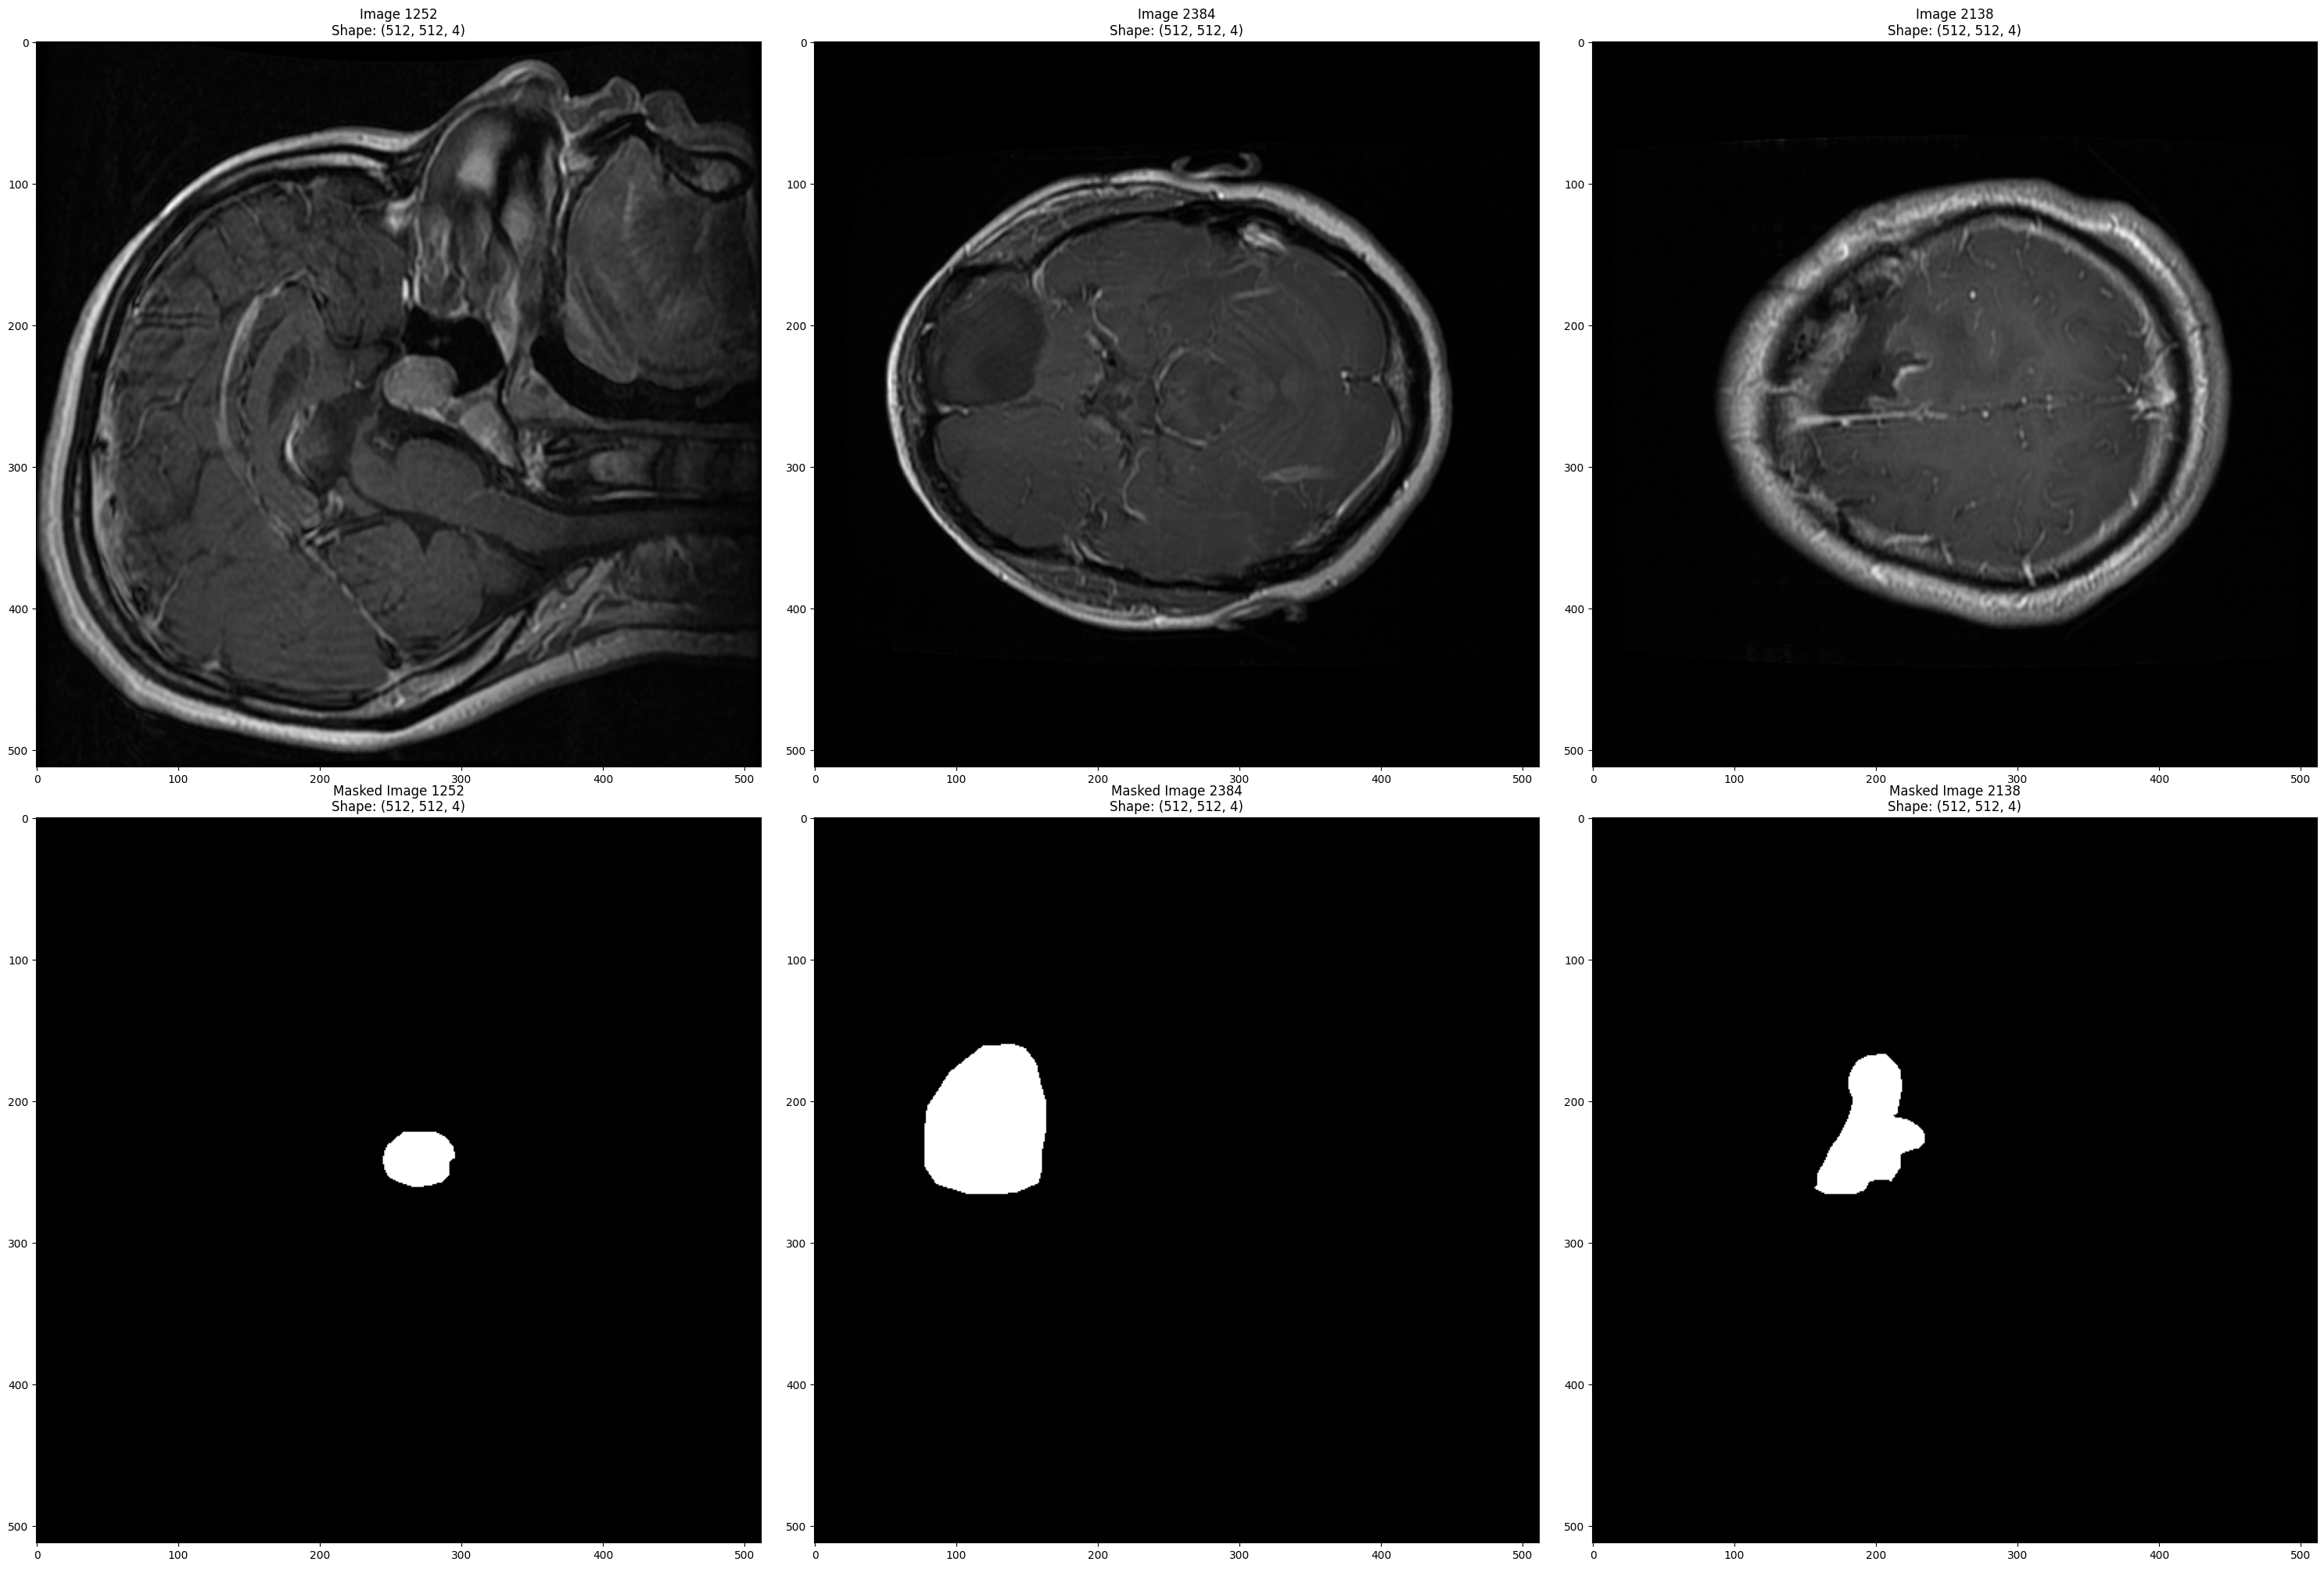

In [15]:
visualize_multiple_images(path1, path2, img, mask, color_map='viridis', fig_size=(10, 10), count=3)

In [11]:
print(brain_df)
cantidad_valores_unicos = brain_df['class'].value_counts()
print(cantidad_valores_unicos)

# Class 1: meningioma (708 cortes)
# Class 2: glioma (1426 cortes)
# Class 3: pituitario (930 cortes)

                      image_path                 mask_path class
1        /content/imagenes/0.png     /content/labels/0.png     1
2        /content/imagenes/1.png     /content/labels/1.png     1
3        /content/imagenes/2.png     /content/labels/2.png     1
4        /content/imagenes/3.png     /content/labels/3.png     1
5        /content/imagenes/4.png     /content/labels/4.png     1
...                          ...                       ...   ...
3060  /content/imagenes/3059.png  /content/labels/3059.png     2
3061  /content/imagenes/3060.png  /content/labels/3060.png     2
3062  /content/imagenes/3061.png  /content/labels/3061.png     2
3063  /content/imagenes/3062.png  /content/labels/3062.png     1
3064  /content/imagenes/3063.png  /content/labels/3063.png     1

[3064 rows x 3 columns]
2    1426
3     930
1     708
Name: class, dtype: int64


In [14]:
# Creo directorio principal donde voy a tener las imagenes
main_directory = './imagenes_fmri'
os.makedirs(main_directory, exist_ok=True)

# Reemplazo en la columna class del data frame los nombres (1,2,3) por (meningioma, glioma, pitutuario)
nombres_nuevos = {
    '1': 'Meningioma',
    '2': 'Glioma',
    '3': 'Pituitario'
}
brain_df['class'] = brain_df['class'].replace(nombres_nuevos)

# Crear carpetas para cada clase (1, 2, 3)
for class_label in ['Meningioma', 'Glioma', 'Pituitario']:
    class_directory = os.path.join(main_directory, str(class_label))
    os.makedirs(class_directory, exist_ok=True)

# Copio las imágenes en los diferentes directorios
for _, row in brain_df.iterrows():
    source_file = row['image_path']
    destination_folder = os.path.join(main_directory, str(row['class']))
    destination_file = os.path.join(destination_folder, os.path.basename(source_file))

    try:
        shutil.copy(source_file, destination_file)
        print(f"Copiando {source_file} a {destination_folder}")
    except Exception as e:
        print(f"Error al copiar {source_file}: {e}")

print("Proceso completado.")
explora_dir(main_directory)

Copiando /content/imagenes/0.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/1.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/2.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/3.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/4.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/5.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/6.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/7.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/8.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/9.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/10.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/11.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/12.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/13.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/14.png a ./imagenes_fmri/Meningioma
Copiando /content/imagenes/15.png a ./imagenes_fmri/Meningioma
Co

<a name='2'></a>
# 2 - Parte A: Clasificación

<a name='2.1'></a>
## 2.1 - Subvivisión del dataset para clasificación

In [16]:
dir_datos = './imagenes_fmri'

os.mkdir('./data')
os.mkdir('./data/train')
os.mkdir('./data/test')

for folder in os.listdir(dir_datos):
    files=os.listdir(os.path.join(dir_datos, folder))
    images=[]
    for f in files:
        try:
            img=tf.io.read_file(os.path.join(dir_datos, folder,f))
            img=tf.image.decode_image(img)
            images.append(f)
        except:
               pass

    random.shuffle(images)
    count=len(images)
    split=int(0.8*count)    # 80% de los datos para test
    os.mkdir(os.path.join('./data/train', folder))
    os.mkdir(os.path.join('./data/test', folder))

    for c in range(split):
        source_file=os.path.join(dir_datos, folder, images[c])
        distination=os.path.join('./data/train', folder, images[c])
        copyfile(source_file, distination)
    for c in range(split,count):
        source_file=os.path.join(dir_datos, folder, images[c])
        distination=os.path.join('./data/test', folder, images[c])
        copyfile(source_file, distination)

In [17]:
dir_train = './data/train'
explora_dir(dir_train)

Existen 3 directorios y 0 imágenes en './data/train'
Existen 0 directorios y 566 imágenes en './data/train/Meningioma'
Existen 0 directorios y 1140 imágenes en './data/train/Glioma'
Existen 0 directorios y 744 imágenes en './data/train/Pituitario'


In [18]:
dir_test = './data/test'
explora_dir(dir_test)

Existen 3 directorios y 0 imágenes en './data/test'
Existen 0 directorios y 142 imágenes en './data/test/Meningioma'
Existen 0 directorios y 286 imágenes en './data/test/Glioma'
Existen 0 directorios y 186 imágenes en './data/test/Pituitario'


<a name='2.2'></a>
## 2.2 - Preparación de los lotes para clasificación

In [19]:
IMAGE_SIZE = (512, 512) # Permite reescalar el preprocesador de keras

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    dir_train,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)

class_names = train_data.class_names    # Para traducir la codificación en enteros
num_classes = len(class_names)          # Para fijar en la capa de salida

test_data=tf.keras.preprocessing.image_dataset_from_directory(
    dir_test,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False
)

Found 2450 files belonging to 3 classes.
Found 614 files belonging to 3 classes.


<a name='2.3'></a>
## 2.3 - Armado del modelo

<a name='2.3.1'></a>
### 2.3.1 - CRNA - modelo y parámetros

In [22]:
# Función para configurar el guardado de los pesos a medida que se va entrenando
def create_model_check_point_callback(checkpoint_path, monitor='val_loss'):
    """
    Toma el camino donde guardar los mejores pesos modelo obtenidos durante el entrenamiento.
    """
    model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        monitor=monitor,
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    )
    return model_checkpoint_cb

In [23]:
# Criterio de parada extra, épocas que espera sin mejorar para detener entrenamiento
earlystop = EarlyStopping(patience=5)
# Ajuste de tasa de aprendizaje automático
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)
# Guardo los datos que se van obteniendo
ModelCheckPoint_model_cb = create_model_check_point_callback('./ModelCheckPoints/model.ckpt')

In [24]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(512,512,3)))       # Importante, input_shape debe ser el tamaño de las imágenes (alto, ancho, canales)
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Flatten())      #Flatten, se utiliza para pasar de 2D a 1D en este caso.
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 126, 126, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      3

<a name='2.3.2'></a>
### 2.3.2 - Entrenamiento

In [25]:
# Entreno el modelo
start_entrenamiento = time.time()
history = model.fit(train_data, epochs=20, batch_size=300, validation_data=test_data, callbacks=[earlystop, learning_rate_reduction, ModelCheckPoint_model_cb])
fin_entrenamiento = time.time()

Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 5.7022 - accuracy: 0.6514
Epoch 1: val_loss improved from inf to 0.57293, saving model to ./ModelCheckPoints/model.ckpt
77/77 [==============================] - 59s 552ms/step - loss: 5.7022 - accuracy: 0.6514 - val_loss: 0.5729 - val_accuracy: 0.7541 - lr: 0.0010
Epoch 2/20
77/77 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8339
Epoch 2: val_loss improved from 0.57293 to 0.35564, saving model to ./ModelCheckPoints/model.ckpt
77/77 [==============================] - 43s 536ms/step - loss: 0.4134 - accuracy: 0.8339 - val_loss: 0.3556 - val_accuracy: 0.8502 - lr: 0.0010
Epoch 3/20
77/77 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.8718
Epoch 3: val_loss improved from 0.35564 to 0.28456, saving model to ./ModelCheckPoints/model.ckpt
77/77 [==============================] - 43s 526ms/step - loss: 0.3349 - accuracy: 0.8718 - val_loss: 0.2846 - val_accuracy: 0.9072 - lr: 

<a name='2.4'></a>
## 2.4 - Evaluación del modelo de clasificación

In [26]:
def plot_curves(history):
    '''
    Devuelve curvas de loss u accuracy, separadas para métricas de entrenamiento y validación.
    '''
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Pérdida en el Entrenamiento")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Precisión en el Entrenamiento")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


# Función para graficar como imagen la matriz de confusión
def plot_confusion_matrix(y_true, y_preds, labels=None, model_name=None, normalize=None):
    """
    Función para graficar la Matrix de confusión
    y_true: vector de salida real
    y_predic: vector de salida predicho por el modelo
    labels: opcional, para nombrar las clases. Lista con strings
    model_name: opcional, para poner un título al gráfico
    normalize: {'true', 'pred', 'all'}, default=None
        Normalizes confusion matrix over the true (rows), predicted (columns)
        conditions or all the population. If None, confusion matrix will not be
        normalized.
    """
    if normalize:
        cm = confusion_matrix(y_true, y_preds, normalize=normalize)
    else:
        cm = confusion_matrix(y_true, y_preds)
    cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
    cmd.plot()
    cmd.ax_.set(xlabel='Clase Predicha', ylabel='Clase Real')
    if model_name:
        cmd.ax_.set(title=model_name)


def load_and_prep_image(filename, img_shape=224, scale=True):
    '''
    lee una imagen del nombre del archivo y la convierte en un tensor,
    y lo remodela al tamaño especificado.

    argumentos:
    filename: ruta a la imagen de destino.
    scale(boolean): especifica si es necesario escalar o no.

    devoluciones:
    tensor de imagen con la forma objetivo.
    '''
    img=tf.io.read_file(filename)
    img=tf.io.decode_image(img, channels=3)
    img=tf.image.resize(img,size=[img_shape,img_shape])

    if scale:
        img=img/255.0
    return img

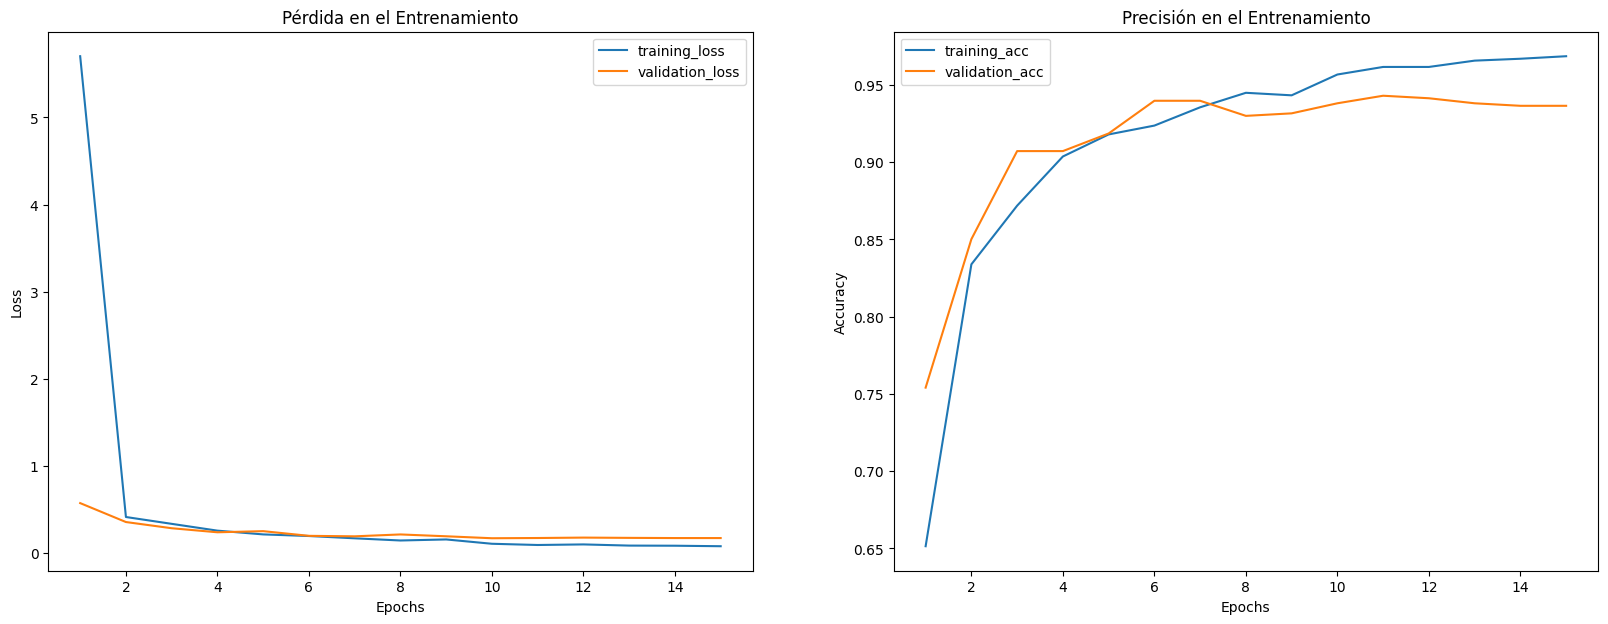

In [27]:
plot_curves(history)

In [28]:
model_result = model.evaluate(test_data)
model_result

20/20 [==============================] - 6s 295ms/step - loss: 0.1717 - accuracy: 0.9365


[0.1717035323381424, 0.9364820718765259]

In [29]:
y_pred = model.predict(test_data)

20/20 [==============================] - 5s 221ms/step


In [30]:
def predict_class(y_pred):
    y_class = []
    for i in y_pred:
        y_class.append(int(np.where(i == np.amax(i))[0]))

    return np.array(y_class)

In [31]:
# Conversión a la clase más probable
y_pred_class = predict_class(y_pred)

In [32]:
# Conversión de las clases reales
y_labels = []
for _,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())

In [33]:
filepaths = []
for filepath in test_data.list_files(dir_test+'/*/*.png',shuffle=False):
    filepaths.append(filepath.numpy())

In [34]:
# Se crea un dataframe con información relacionada a las predicciones
pred_df=pd.DataFrame({
    'filepaths':filepaths,
    'y_true':y_labels,
    'y_pred':y_pred_class,
    'pred_conf':y_pred.max(axis=1),
    'actual_class_name':[class_names[i] for i in y_labels],
    'pred_class_name':[class_names[i] for i in y_pred_class]
     })
pred_df.head()

,filepaths,y_true,y_pred,pred_conf,actual_class_name,pred_class_name
0,b'./data/test/Glioma/1842.png',0,0,1.000000,Glioma,Glioma
1,b'./data/test/Glioma/1845.png',0,0,1.000000,Glioma,Glioma
2,b'./data/test/Glioma/1851.png',0,0,1.000000,Glioma,Glioma
3,b'./data/test/Glioma/1852.png',0,0,1.000000,Glioma,Glioma
4,b'./data/test/Glioma/1861.png',0,0,0.999526,Glioma,Glioma


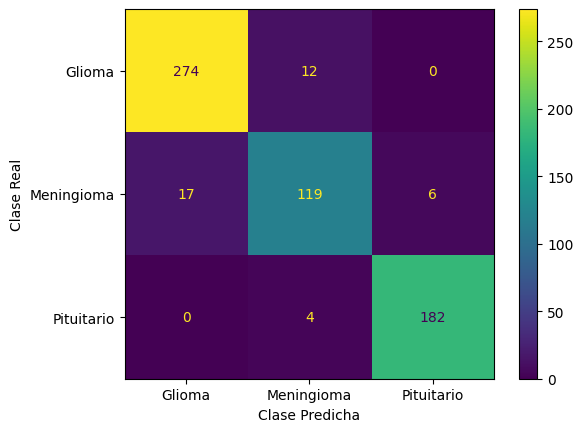

In [35]:
plot_confusion_matrix(pred_df['y_true'], pred_df['y_pred'], labels=class_names)

In [39]:
print(classification_report(pred_df['y_true'], pred_df['y_pred'], target_names=class_names))

              precision    recall  f1-score   support

      Glioma       0.94      0.96      0.95       286
  Meningioma       0.88      0.84      0.86       142
  Pituitario       0.97      0.98      0.97       186

    accuracy                           0.94       614
   macro avg       0.93      0.92      0.93       614
weighted avg       0.94      0.94      0.94       614



In [40]:
# Se filtran las imágenes que no ha podido clasificar correctamente
pred_wrong_df = pred_df[pred_df['y_true']!=pred_df['y_pred']].reset_index(drop=True)
pred_wrong_df.head()

,filepaths,y_true,y_pred,pred_conf,actual_class_name,pred_class_name
0,b'./data/test/Glioma/752.png',0,1,0.561539,Glioma,Meningioma
1,b'./data/test/Glioma/756.png',0,1,0.655080,Glioma,Meningioma
2,b'./data/test/Glioma/758.png',0,1,0.715495,Glioma,Meningioma
3,b'./data/test/Glioma/761.png',0,1,0.587463,Glioma,Meningioma
4,b'./data/test/Glioma/779.png',0,1,0.875432,Glioma,Meningioma


In [41]:
pred_wrong_df.shape

(39, 6)

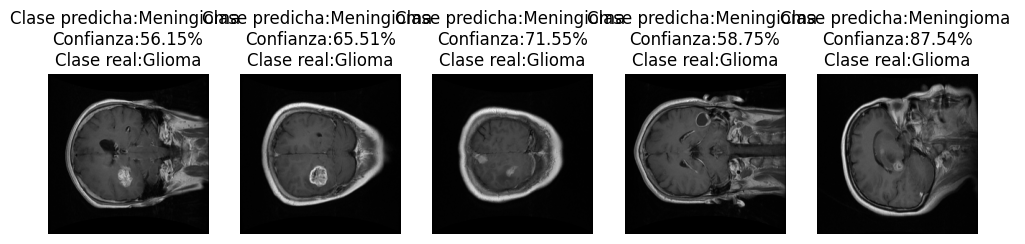

In [42]:
# Visualizar imágenes en las que se equivocó
images_to_view = 5  # Cantidad
start_index = 0     # Desde dónde comienza del df
plt.figure(figsize=(12,10))
for i,row in enumerate(pred_wrong_df[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3,5,i+1)
    img=load_and_prep_image(row[1],scale=False)
    _,_,_,_,pred_p,act_cls,prd_cls=row
    plt.imshow(img/255.0)
    plt.title(f"Clase predicha:{prd_cls} \nConfianza:{pred_p*100:.2f}%\nClase real:{act_cls}")
    plt.axis(False)

<a name='3'></a>
# 3 - Parte B: Segmentación

<a name='3.1'></a>
## 3.1 - Process Data to segmentation

In [43]:
def visualize_multiple_images_preprocess(img, mask, color_map_img='jet', color_map_mask='gray', fig_size=(10, 10), count=3):

    fig, arr = plt.subplots(3, count, figsize=(fig_size[0]*count, fig_size[1]*2))

    for j in range(count):
        iDx = random.randint(0, len(img) - 1)
        img_view = X[iDx]
        mask_view = y[iDx]

        arr[0, j].imshow(img_view, cmap=color_map_img, vmin=0, vmax=1)
        arr[0, j].set_title(f'Image {iDx}\nShape: {img_view.shape}')
        arr[1, j].imshow(img_view, cmap='gray', vmin=0, vmax=1)
        arr[1, j].set_title(f'Image {iDx}\nShape: {img_view.shape}')
        arr[2, j].imshow(mask_view, cmap=color_map_mask, vmin=0, vmax=1)
        arr[2, j].set_title(f'Masked Image {iDx}\nShape: {mask_view.shape}')

    plt.tight_layout()
    plt.show()

In [44]:
path1 = '/content/imagenes/'
path2 = '/content/labels/'

#Cargo las imagenes y máscaras
img, mask = LoadData(path1, path2)

# Se define la nueva resolución, en este caso se baja de 227 a 128
target_shape_img = [128, 128, 1]    # 1 canal, Escala de grises
target_shape_mask = [128, 128, 1]   # 1 canal la máscara, es o no es

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# Deberían haber 2 clases: fondo y la de interés.  ###### IMPORTANTE #######
print(np.unique(y))

X Shape: (3064, 128, 128, 1)
Y shape: (3064, 128, 128, 1)
[0 1]


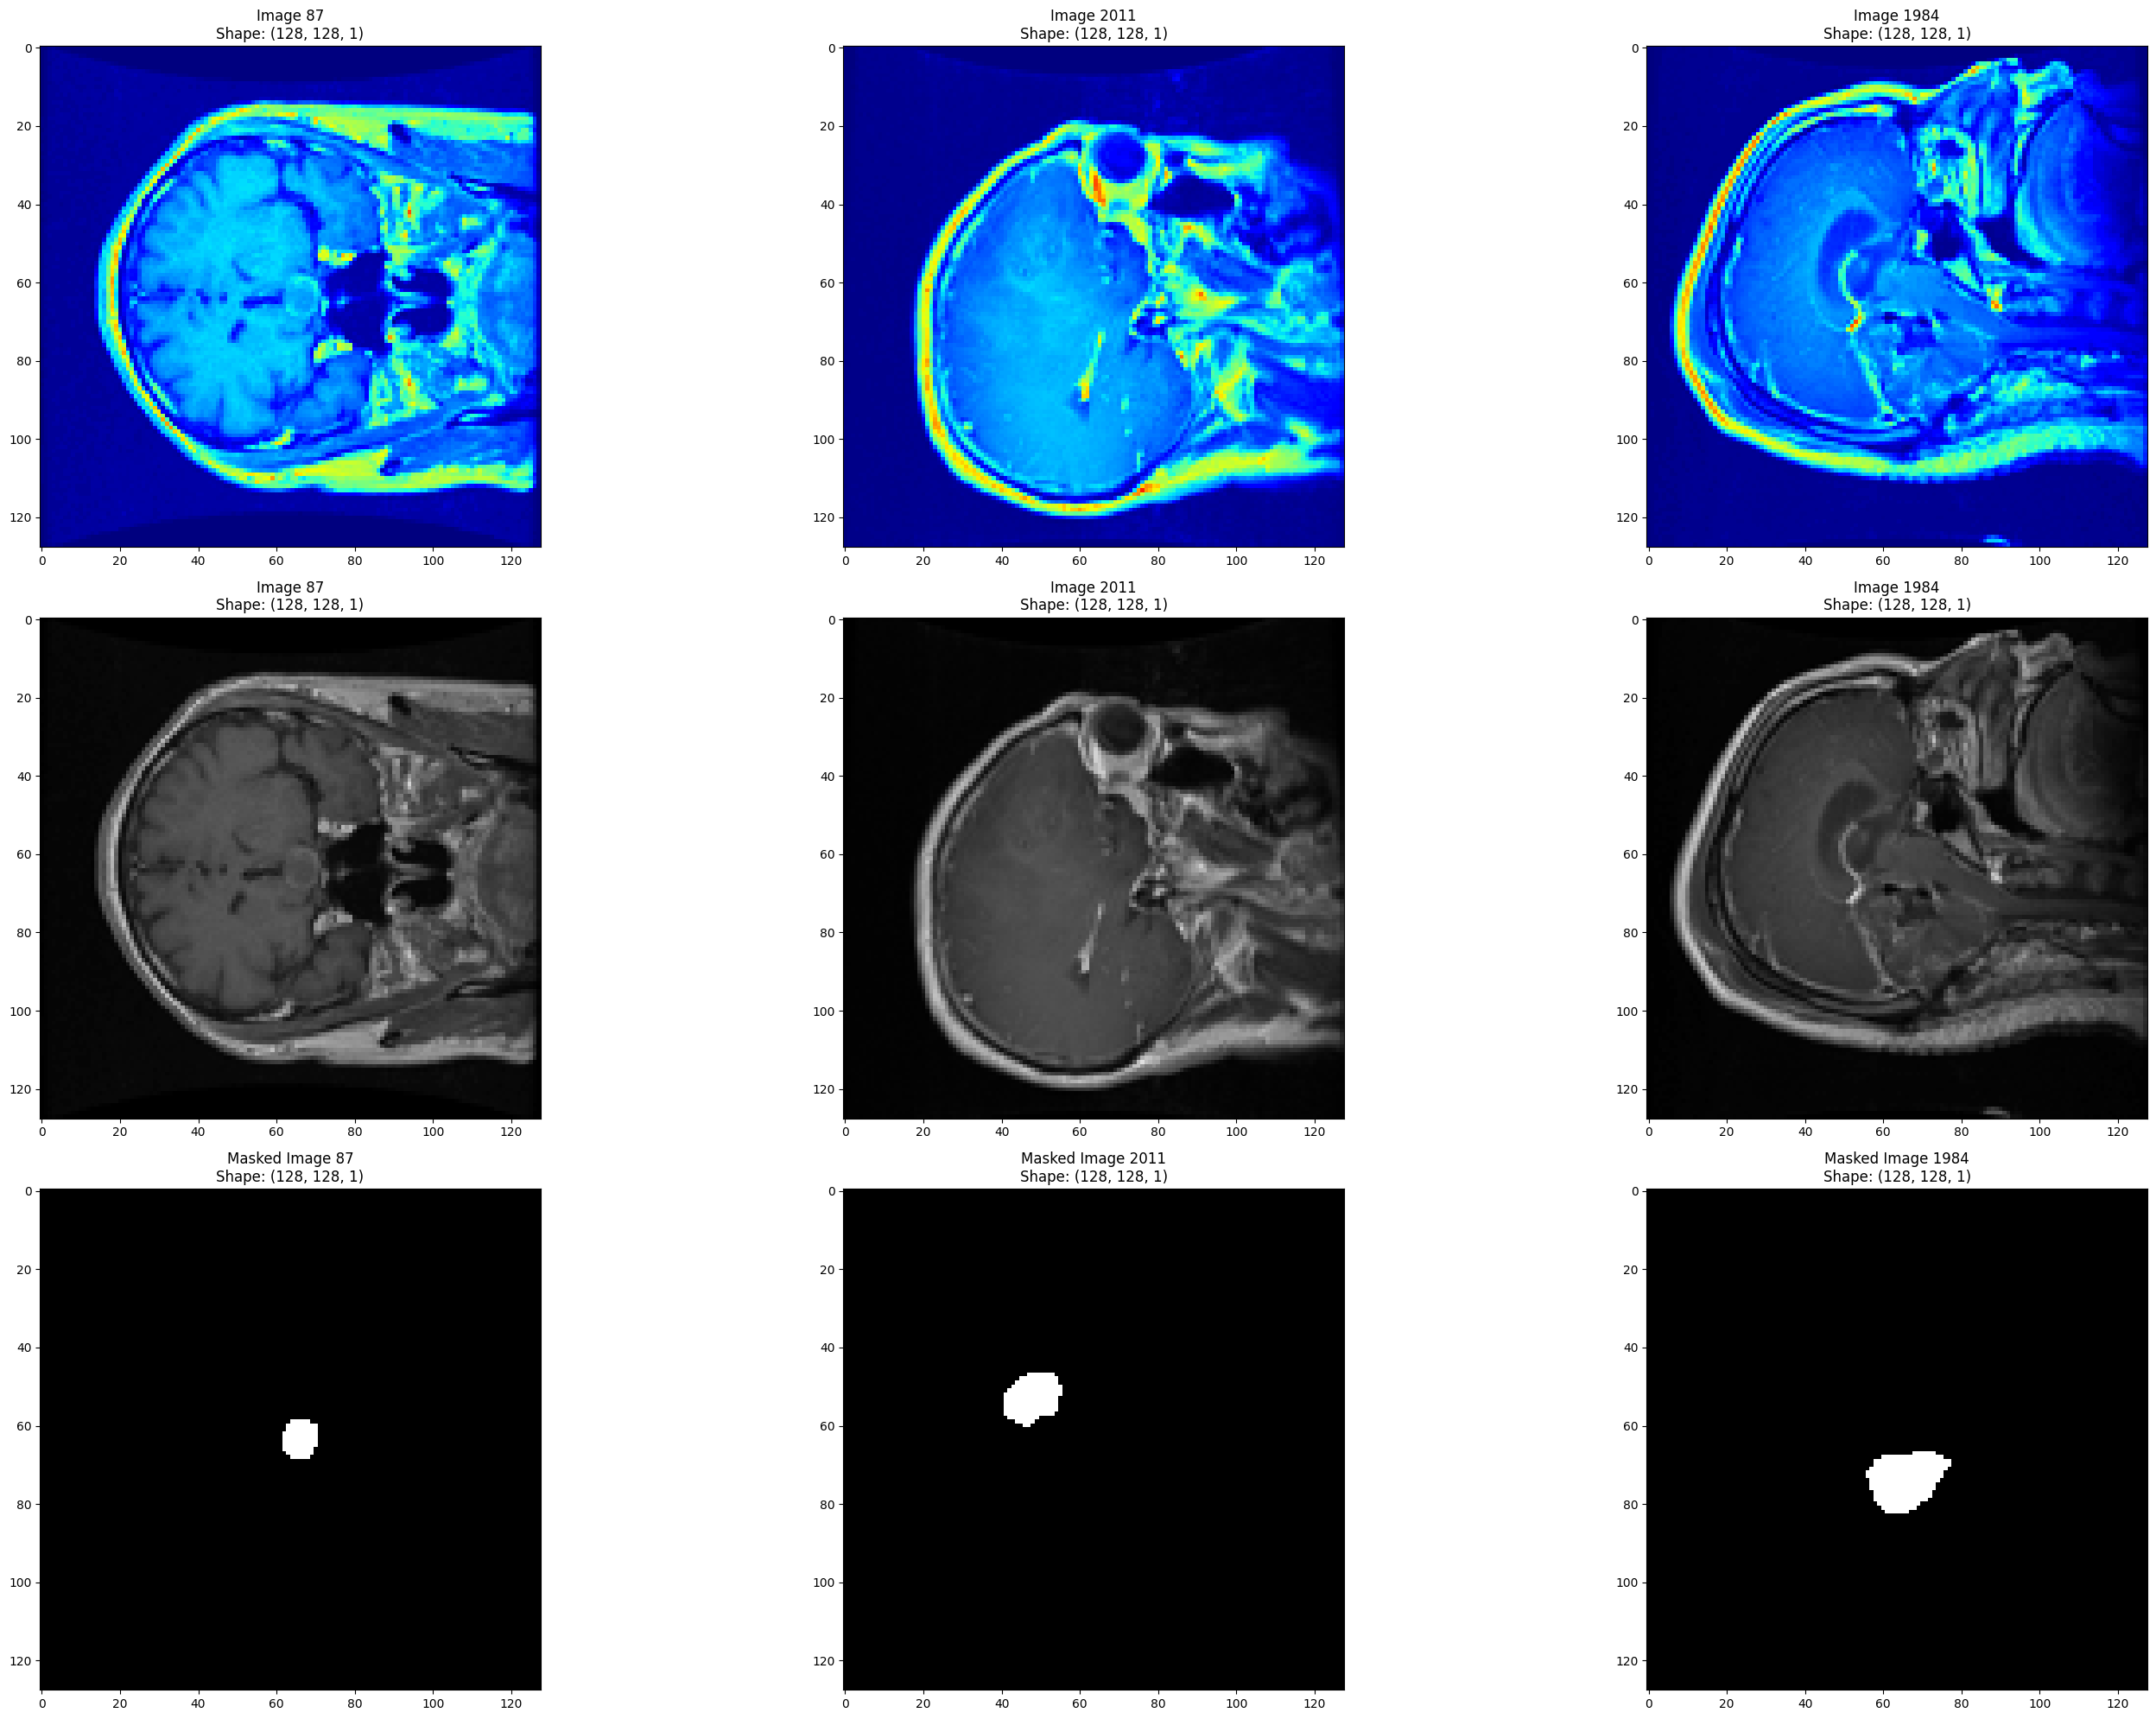

In [45]:
visualize_multiple_images_preprocess(X, y, color_map_img='jet', color_map_mask='gray', fig_size=(10, 10), count=3)

<a name='3.2'></a>
## 3.2 - Split Train and Test Set


In [46]:
# Armo un set de test (para evaluar resultados al final)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
# Armo el set de train/validación para entrenar el modelo
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

<a name='3.3'></a>
## 3.3 - Armado del modelo

<a name='3.3.1'></a>
### 3.3.1 - U-Net Encoder Block

In [47]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection

<a name='3.3.2'></a>
### 3.3.2 - U-Net Decoder Block

In [48]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

<a name='3.3.3'></a>
### 3.3.3 - Compile U-Net Blocks

In [49]:
def UNetCompiled(input_size=(128, 128, 1), n_filters=32, n_classes=2):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output
    """
    # Input size represent the size of 1 image (the size used for pre-processing)
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size.
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='3.3.4'></a>
## 3.3.4 - Compile and Run Model

In [50]:
# Se construye el modelo con las características deseadas
unet = UNetCompiled(input_size=(128,128,1), n_filters=32, n_classes=2)

In [51]:
# Check the summary to better interpret how the output dimensions change in each layer
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 128, 128, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d_4[0][0]']            
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d_5[0][0]']            
 Normalization)                                                                               

In [52]:
# from tensorflow.keras.metrics import MeanIoU


# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.OneHotMeanIoU(num_classes=2, name="iou", sparse_y_pred=False),
                       tf.keras.metrics.KLDivergence(name="kld"),
                       'accuracy'])

In [53]:
# Run the model in a mini-batch fashion and compute the progress for each epoch
start_entrenamiento = time.time()
results = unet.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_valid, y_valid))
fin_entrenamiento = time.time()

Epoch 1/40
62/62 [==============================] - 35s 318ms/step - loss: 0.1375 - iou: 0.5000 - kld: 0.2598 - accuracy: 0.9838 - val_loss: 0.0589 - val_iou: 1.0000 - val_kld: 0.2631 - val_accuracy: 0.9838
Epoch 2/40
62/62 [==============================] - 15s 243ms/step - loss: 0.0568 - iou: 1.0000 - kld: 0.2652 - accuracy: 0.9839 - val_loss: 0.0595 - val_iou: 1.0000 - val_kld: 0.2656 - val_accuracy: 0.9838
Epoch 3/40
62/62 [==============================] - 14s 232ms/step - loss: 0.0533 - iou: 0.5000 - kld: 0.2941 - accuracy: 0.9839 - val_loss: 0.0525 - val_iou: 0.5000 - val_kld: 0.2827 - val_accuracy: 0.9838
Epoch 4/40
62/62 [==============================] - 15s 240ms/step - loss: 0.0487 - iou: 0.4988 - kld: 0.3278 - accuracy: 0.9848 - val_loss: 0.0461 - val_iou: 0.4994 - val_kld: 0.3074 - val_accuracy: 0.9848
Epoch 5/40
62/62 [==============================] - 14s 234ms/step - loss: 0.0490 - iou: 0.4983 - kld: 0.3263 - accuracy: 0.9850 - val_loss: 0.0484 - val_iou: 0.4989 - val_

In [54]:
print("Tiempo de entrenamiento: {:.4f} s".format(fin_entrenamiento-start_entrenamiento))

Tiempo de entrenamiento: 605.8250 s


<a name='3.4'></a>
## 3.4 - Evaluación del modelo de clasificación

<a name='3.4.1'></a>
### 3.4.1 - Bias Variance Check

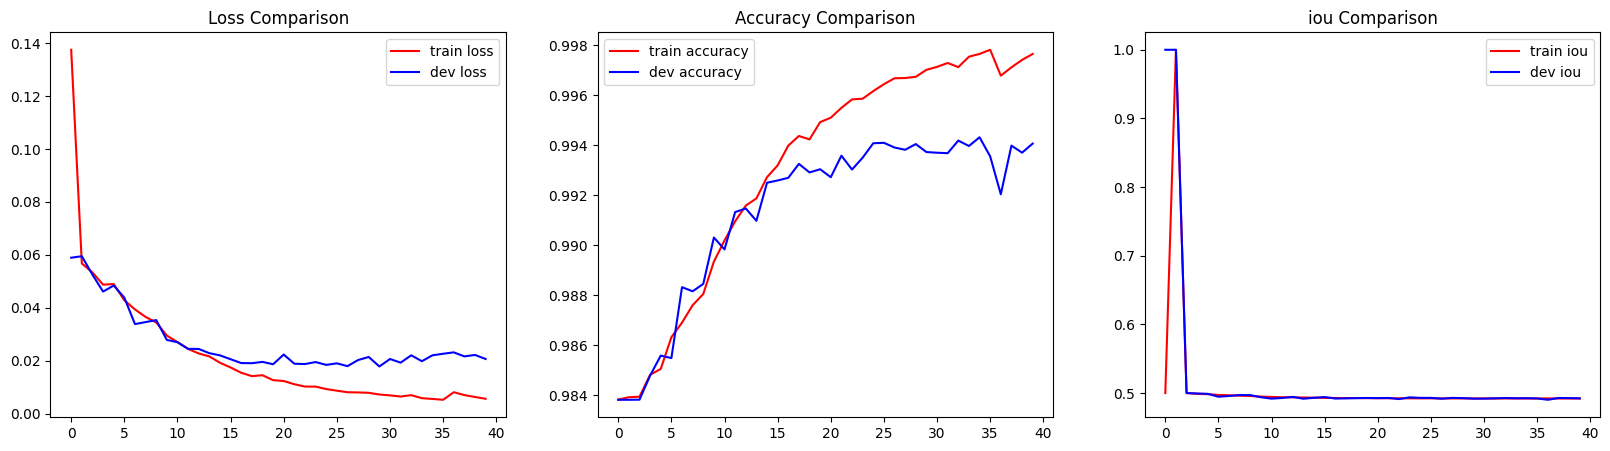

In [55]:
# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plit the graphs for accuracy
# I have plotted for loss too, this helps in confirming if the loss is decreasing with each iteration - hence, the model is optimizing fine
fig, axis = plt.subplots(1, 3, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()

axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

axis[2].plot(results.history["iou"], color='r', label = 'train iou')
axis[2].plot(results.history["val_iou"], color='b', label = 'dev iou')
axis[2].set_title('iou Comparison')
axis[2].legend()

# RESULTS
# The train loss is consistently decreasing showing that Adam is able to optimize the model and find the minima
# The accuracy of train and validation is ~90% which is high enough, so low bias
# and the %s aren't that far apart, hence low variance

<a name='3.4.2'></a>
### 3.4.2 - View Predicted Segmentations

In [56]:
from skimage.measure import find_contours
from skimage.segmentation import mark_boundaries


def VisualizeResults(num_predictions):

    fig, axes = plt.subplots(num_predictions, 5, figsize=(15, 3*num_predictions))

    for i in range(num_predictions):

        iDx = np.random.randint(len(X_test))

        img = X_test[iDx]
        img = img[np.newaxis, ...]

        # Predicción de la imagen
        start_predict = time.time()
        pred_y = unet.predict(img)
        pred_mask = tf.argmax(pred_y[0], axis=-1)
        pred_mask = pred_mask[..., tf.newaxis]
        end_predict = time.time()
        ##########################

        # Binarización de la máscara
        threshold = 0.5
        binary_mask = tf.cast(pred_mask[:,:,0] > tf.cast(threshold, pred_mask.dtype), pred_mask.dtype)

        # Diferencia entre máscara predicha y real
        diff_mask = y_test[iDx, :, :, 0] - binary_mask.numpy()

        # Mostrar resultados en una fila diferente
        axes[i, 0].imshow(X_test[iDx], cmap='gray')
        axes[i, 0].set_title(f'Processed Image {iDx}')

        axes[i, 1].imshow(y_test[iDx,:,:,0], cmap='gray')
        axes[i, 1].set_title(f'Actual Masked Image {iDx}')

        axes[i, 2].imshow(pred_mask[:,:,0], cmap='gray')
        axes[i, 2].set_title(f'Predicted Masked Image {iDx}')

        axes[i, 3].imshow(diff_mask, cmap='coolwarm', vmin=-1, vmax=1)
        axes[i, 3].set_title(f'Difference Mask {iDx}')

        axes[i, 4].imshow(X_test[iDx], cmap='gray')
        axes[i, 4].imshow(pred_mask, cmap='jet', alpha=0.5)
        axes[i, 4].set_title(f'Overlapping Predicted Mask {iDx}')
        axes[i, 4].axis('off')

        # Ver tiempo de predicción
        print(f"Tiempo de predicción de la imagen {iDx}: {end_predict-start_predict:.4f} s")

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 22ms/step
Tiempo de predicción de la imagen 98: 0.0622 s
1/1 [==============================] - 0s 22ms/step
Tiempo de predicción de la imagen 271: 0.0685 s
1/1 [==============================] - 0s 18ms/step
Tiempo de predicción de la imagen 234: 0.0578 s
1/1 [==============================] - 0s 27ms/step
Tiempo de predicción de la imagen 222: 0.0636 s


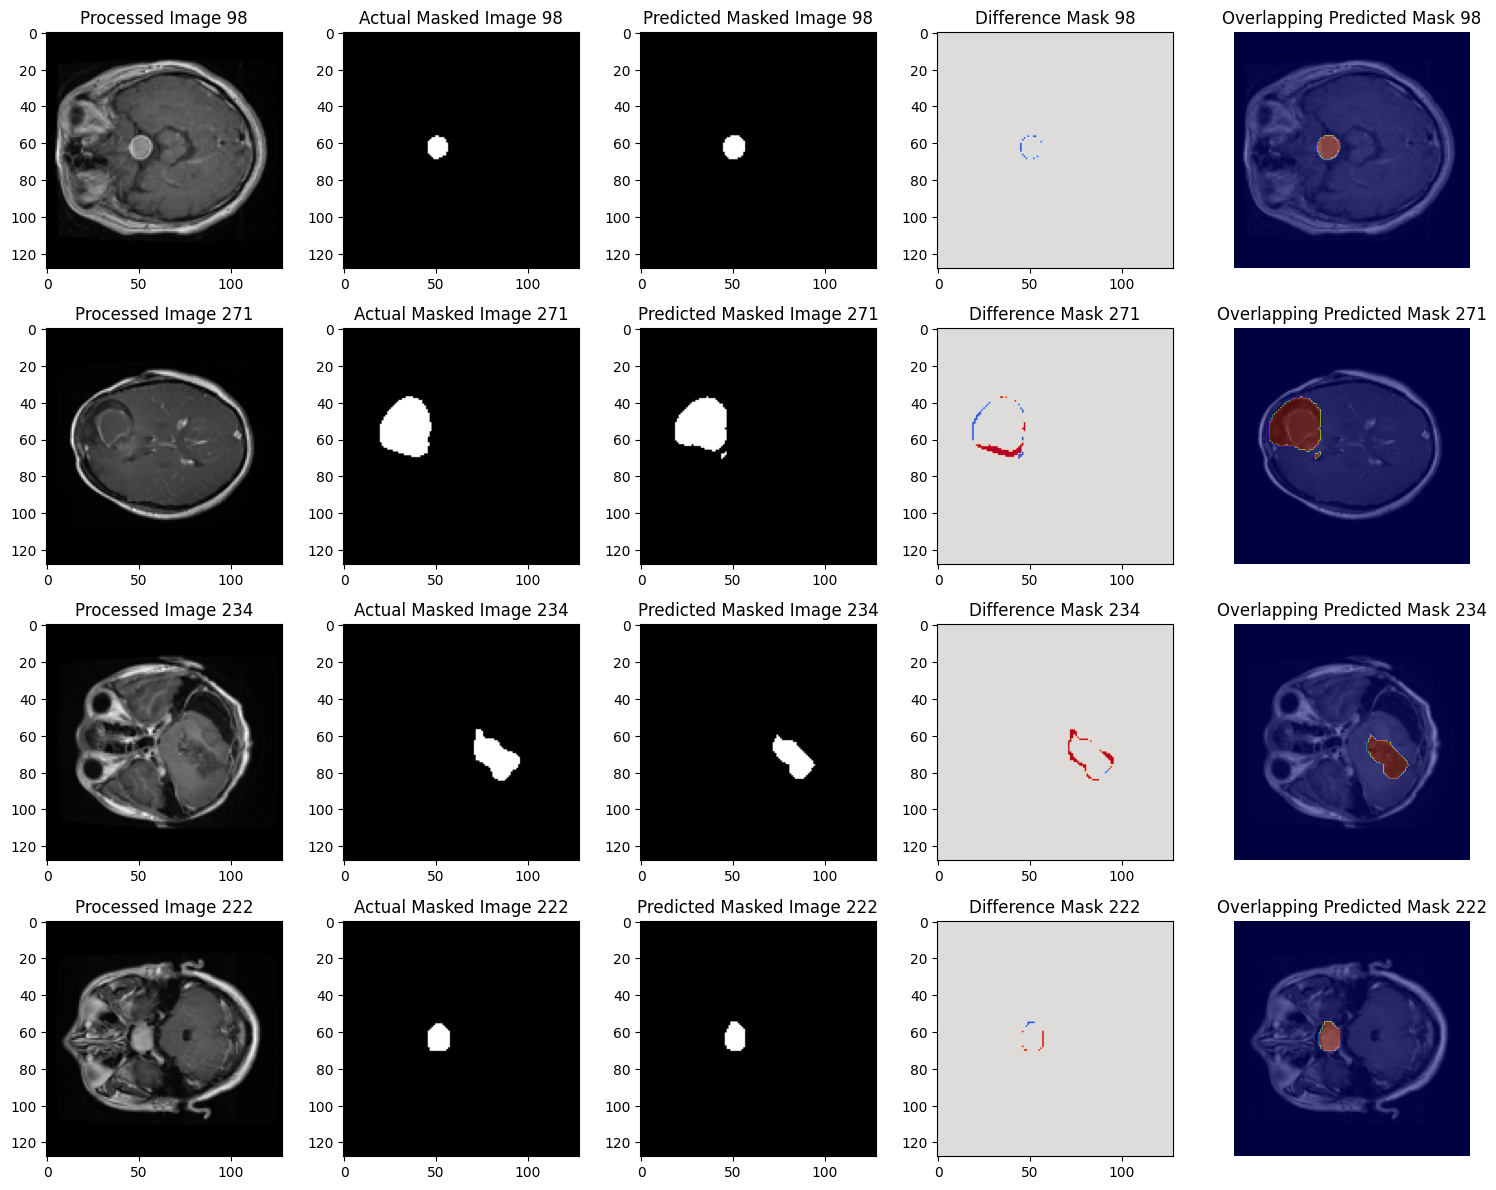

In [60]:
# Elegir índice para mostrar la imágen en cuestión: original escalada, máscara original escalada, máscara predicha
index = 4
VisualizeResults(index)